<a href="https://colab.research.google.com/github/uakarsh/docformer/blob/master/examples/docformer_pl/2_Pre_training_DocFormer_Task_Making_the_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Refer here for the dataset: https://github.com/furkanbiten/idl_data 
# (IDL dataset was also used in the pre-training of LaTr), might take time to download the dataset

!wget http://datasets.cvc.uab.es/UCSF_IDL/Samples/ocr_imgs_sample.zip
!unzip /content/ocr_imgs_sample.zip
!rm /content/ocr_imgs_sample.zip

In [ ]:
## Installing the dependencies (might take some time)

%%capture
!pip install pytesseract
!sudo apt install tesseract-ocr
!pip install transformers
!pip install pytorch-lightning
!pip install einops
!pip install accelerate
!pip install tqdm
!pip install 'Pillow==7.1.2'

In [ ]:
## Cloning the repository

%%capture
!git clone https://github.com/uakarsh/docformer.git

In [ ]:
## Importing the libraries

import os
import pickle
import pytesseract
import numpy as np
import pandas as pd
from PIL import Image,ImageDraw
import json

import torch
from torchvision.transforms import ToTensor
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader

import math
import torch.nn.functional as F
import torchvision.models as models
from einops import rearrange
from torch import Tensor

## Adding the path of docformer to system path
import sys
sys.path.append('/content/docformer/src/docformer/')

## Importing the functions from the DocFormer Repo
from dataset import create_features, resize_align_bbox
from modeling import DocFormerEncoder,ResNetFeatureExtractor,DocFormerEmbeddings,LanguageFeatureExtractor
from transformers import BertTokenizerFast
from utils import load_json_file, get_specific_file

## 1. Dataset loading

In [ ]:
## Making the json entries

json_path = '/content/sample/OCR'
pdf_path = '/content/sample/pdfs'
json_entries = []
resize_shape = (1000, 1000)

target_size = resize_shape
width, height = target_size

for i in os.listdir(json_path):
  base_path = os.path.join(json_path, i)
  for j in os.listdir(base_path):
    json_entries.append(os.path.join(base_path, j))

In [ ]:
def get_words_and_coordinates(tif_path, sample_entry):
    ## Making the list for storing the words and coordinates
    words = []
    coordinates = []

    ## Storing the current box

    original_image_size = Image.open(tif_path).convert("RGB").size
    for i in sample_entry[1]['Blocks']:
      if i['BlockType']=='WORD' and i['Page']==1:
        words.append(i['Text'].lower())
        curr_box = i['Geometry']['BoundingBox']
        xmin, ymin, xmax, ymax = curr_box['Left'], curr_box['Top'], curr_box['Width']+ curr_box['Left'], curr_box['Height']+ curr_box['Top']
        curr_bbox =  resize_align_bbox(tuple([xmin, ymin, xmax, ymax]), 1, 1, *original_image_size)
        coordinates.append(curr_bbox)

    return words, coordinates

In [ ]:
class DocumentDataset(Dataset):

  def __init__(self, json_entries, pdf_path, target_size, tokenizer, max_len = 512, use_mlm = False):
    self.json_entries = json_entries
    self.pdf_path = pdf_path
    self.target_size = target_size
    self.tokenizer = tokenizer
    self.max_len = max_len
    self.use_mlm = use_mlm

  def __len__(self):
    return len(self.json_entries)

  def __getitem__(self, idx):

    ## Loading json file
    sample_entry = load_json_file(json_entries[idx])

    ## Loading tif folder
    sample_tif_file = os.path.join(pdf_path, sample_entry[0].split('/')[-1])

    ## Loading the tif path
    tif_path = get_specific_file(sample_tif_file)

    words, coordinates = get_words_and_coordinates(tif_path, sample_entry)
    
    final_encoding = create_features(
            tif_path,
            tokenizer,
            add_batch_dim=False,
            target_size=self.target_size,
            max_seq_length=self.max_len,
            path_to_save=None,
            save_to_disk=False,
            apply_mask_for_mlm=self.use_mlm,
            extras_for_debugging=False,
            use_ocr = False,
            bounding_box = coordinates,
            words = words
    )

    return final_encoding

In [ ]:
## Defining the tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [ ]:
dataset = DocumentDataset(
    json_entries = json_entries, 
    pdf_path = pdf_path, 
    target_size = target_size, 
    tokenizer = tokenizer,
    max_len = 512,
    use_mlm = True
)

In [ ]:
idx = 44
final_encoding = dataset[idx]

In [ ]:
from torchvision.transforms import ToPILImage
new_image = ToPILImage()(final_encoding['resized_scaled_img'])
new_coordinates = final_encoding['resized_and_aligned_bounding_boxes']

In [ ]:
draw = ImageDraw.Draw(new_image)  

for curr_box in new_coordinates:
  # create rectangle image
  curr_box = tuple(curr_box.tolist())
  # curr_box = [tuple(curr_box[:2]), tuple(curr_box[2:])]
  x0, y0, x1, y1 = curr_box
  draw.rectangle(xy = [(x0, y0), (x1, y1)], outline = 'purple')

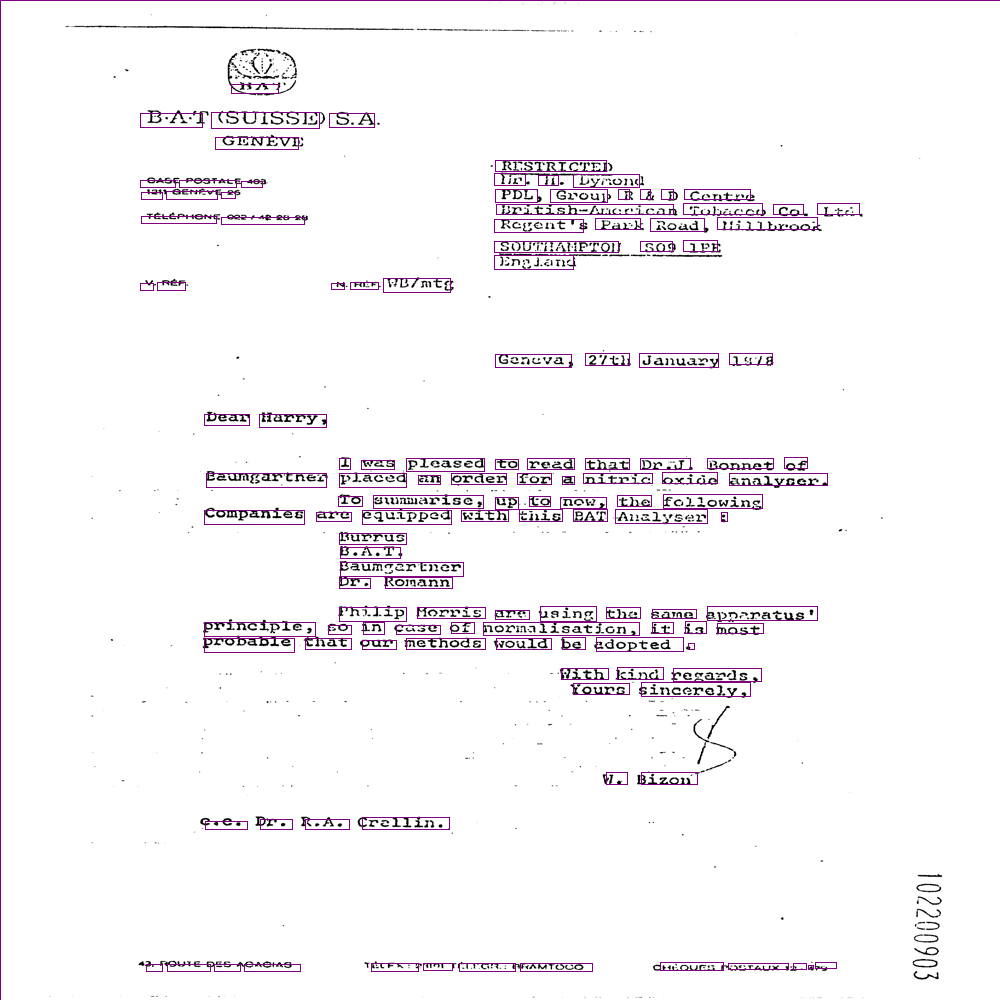

In [ ]:
new_image

In [ ]:
def collate_fn(data_bunch):

  '''
  A function for the dataloader to return a batch dict of given keys

  data_bunch: List of dictionary values
  '''

  dict_data_bunch = {}

  for i in data_bunch:
    for (key, value) in i.items():
      if key not in dict_data_bunch:
        dict_data_bunch[key] = []
      dict_data_bunch[key].append(value)

  for key in list(dict_data_bunch.keys()):
      dict_data_bunch[key] = torch.stack(dict_data_bunch[key], axis = 0)
  return dict_data_bunch

In [ ]:
dl = DataLoader(dataset, batch_size = 4, collate_fn = collate_fn)

In [ ]:
batch_encoding = next(iter(dl))

In [ ]:
for key in list(batch_encoding.keys()):
  print_statement = '{0: <50}'.format(str(key) + " has a shape:")
  print(print_statement, batch_encoding[key].shape)

resized_scaled_img has a shape:                    torch.Size([4, 3, 1000, 1000])
x_features has a shape:                            torch.Size([4, 512, 8])
y_features has a shape:                            torch.Size([4, 512, 8])
input_ids has a shape:                             torch.Size([4, 512])
resized_and_aligned_bounding_boxes has a shape:    torch.Size([4, 512, 4])
mlm_labels has a shape:                            torch.Size([4, 512])
